In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir

import tensorflow as tf

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GRU

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score



In [8]:
beginner_path = 'beginner_expert_processedData/beginner/beginner_'
expert_path = 'beginner_expert_processedData/expert/expert_'
left_column = [
#'Time','Distance','Corr Dist','Corr Dist (Unstretched)','Session Time Left',
'GPS Latitude','GPS Longitude','Damper Velocity (Calc) FL','Damper Velocity (Calc) FR','Damper Velocity (Calc) RL',
'Damper Velocity (Calc) RR','Corr Speed','Brake Pos',
'CG Accel Lateral','CG Accel Longitudinal','CG Accel Vertical','CG Height','Camber FL','Camber FR','Camber RL','Camber RR','Car Coord X',
'Car Coord Y','Car Coord Z','Car Pos Norm','Chassis Pitch Angle','Chassis Pitch Rate','Chassis Roll Angle','Chassis Roll Rate',
'Chassis Velocity X','Chassis Velocity Y','Chassis Velocity Z','Chassis Yaw Rate','Drive Train Speed','Engine RPM','Ground Speed',
'Ride Height FL','Ride Height FR','Ride Height RL','Ride Height RR','Road Temp','Self Align Torque FL','Self Align Torque FR',
'Self Align Torque RL','Self Align Torque RR','Steering Angle','Suspension Travel FL','Suspension Travel FR',
'Suspension Travel RL','Suspension Travel RR','Tire Load FL','Tire Load FR','Tire Load RL','Tire Load RR','Tire Loaded Radius FL',
'Tire Loaded Radius FR','Tire Loaded Radius RL','Tire Loaded Radius RR','Tire Pressure FL','Tire Pressure FR','Tire Pressure RL','Tire Pressure RR',
'Tire Rubber Grip FL','Tire Rubber Grip FR','Tire Rubber Grip RL','Tire Rubber Grip RR','Tire Slip Angle FL','Tire Slip Angle FR',
'Tire Slip Angle RL','Tire Slip Angle RR','Tire Slip Ratio FL','Tire Slip Ratio FR','Tire Slip Ratio RL','Tire Slip Ratio RR',
'Tire Temp Core FL','Tire Temp Core FR','Tire Temp Core RL','Tire Temp Core RR','Tire Temp Inner FL','Tire Temp Inner FR',
'Tire Temp Inner RL','Tire Temp Inner RR','Tire Temp Middle FL','Tire Temp Middle FR','Tire Temp Middle RL',
'Tire Temp Middle RR','Tire Temp Outer FL','Tire Temp Outer FR','Tire Temp Outer RL','Tire Temp Outer RR','Toe In FL',
'Toe In FR','Toe In RL','Toe In RR','Wheel Angular Speed FL','Wheel Angular Speed FR','Wheel Angular Speed RL','Wheel Angular Speed RR',
'CG Distance','Lateral Velocity','Longitudinal Velocity','Lateral Acceleration','Longitudinal Acceleration']

selected_column = ['Brake Pos', 'Ground Speed', 'Steering Angle', 'Throttle Pos', 'Chassis Yaw Rate', 'Chassis Velocity X', 
               'Chassis Velocity Y','Chassis Velocity Z','Lateral Velocity','Longitudinal Velocity','Lateral Acceleration','Longitudinal Acceleration', 
               'CG Distance']

curveList = [[103.9, 209.3], [316.6, 399.6], [425.3, 517.9], [590.5, 756.9], [1048.7, 1110.5], [1212.3, 1437.1]]


98

# Generate WHOLE corner's data

In [14]:
def generate_allcorner_data(features):
    sequences = list()
    final_df = pd.DataFrame()
    for i in range(1,20):
        final_df = pd.DataFrame()
        file_path = beginner_path + str(i) + '_new2.csv'
        df = pd.read_csv(file_path, header=0)
        df = df.dropna()
        df = df.astype(float)

        for j in range(0, 6):
          tmp_df = df[(df['Distance'] >= curveList[j][0]) & (df['Distance'] <= curveList[j][1])]
          tmp_df = tmp_df.loc[:,features]
          tmp_df['curve_num'] = j
          values = tmp_df.values
          scaler = MinMaxScaler(feature_range=(0, 1))
          scaled = scaler.fit_transform(values)
          sequences.append(values)


    for i in range(1,20):
        final_df = pd.DataFrame()
        file_path = expert_path + str(i) + '_new2.csv'
        df = pd.read_csv(file_path, header=0)
        df = df.dropna()
        df = df.astype(float)
        for j in range(0, 6):
          tmp_df = df[(df['Distance'] >= curveList[j][0]) & (df['Distance'] <= curveList[j][1])]
          tmp_df = tmp_df.loc[:,features]
          tmp_df['curve_num'] = j
          values = tmp_df.values
          scaler = MinMaxScaler(feature_range=(0, 1))
          scaled = scaler.fit_transform(values)
          sequences.append(values)
            
    targets = pd.read_csv('target.csv')
    targets = targets.values[:,1]
    groups = pd.read_csv('group.csv', header=0)
    groups = groups.values[:,1]

    len_sequences = []
    for one_seq in sequences:
        len_sequences.append(len(one_seq))
    pd.Series(len_sequences).describe()

    #Padding the sequence with the values in last row to max length
    to_pad = max(len_sequences)
    new_seq = []
    for one_seq in sequences:
        len_one_seq = len(one_seq)
        last_val = one_seq[-1]
        n = to_pad - len_one_seq
        to_concat = np.repeat(one_seq[-1], n).reshape(len(features)+1, n).transpose()
        new_one_seq = np.concatenate([one_seq, to_concat])
        new_seq.append(new_one_seq)
    final_seq = np.stack(new_seq)

    seq_len = 60
    final_seq=sequence.pad_sequences(final_seq, maxlen=seq_len, padding='post', dtype='float', truncating='post')

    # Modifying Sequence
    train = [final_seq[i] for i in range(len(final_seq)) if (groups[int(i/6)]==1)]
    validation = [final_seq[i] for i in range(len(final_seq)) if groups[int(i/6)]==2]
    test = [final_seq[i] for i in range(len(final_seq)) if groups[int(i/6)]==3]

    train_target = [targets[int(i/6)] for i in range(len(final_seq)) if (groups[int(i/6)]==1)]
    validation_target = [targets[int(i/6)] for i in range(len(final_seq)) if groups[int(i/6)]==2]
    test_target = [targets[int(i/6)] for i in range(len(final_seq)) if groups[int(i/6)]==3]

    train = np.array(train)
    validation = np.array(validation)
    test = np.array(test)

    train_target = np.array(train_target)
    validation_target = np.array(validation_target)
    test_target = np.array(test_target)

    print(train.shape)
    print(train_target.shape)
    
    return train, validation, test, train_target, validation_target, test_target

## Generate one corner's data

In [32]:
def generate_onecorner_sequences(corner_num, features):
    sequences = list()
    final_df = pd.DataFrame()
    corner_num = 0
    for i in range(1,20):
        final_df = pd.DataFrame()
        file_path = beginner_path + str(i) + '_new2.csv'
        df = pd.read_csv(file_path, header=0)
        df = df.dropna()
        df = df.astype(float)
        tmp_df = df[(df['Distance'] >= curveList[corner_num][0]) & (df['Distance'] <= curveList[corner_num][1])]
        tmp_df = tmp_df.loc[:,features]
        values = tmp_df.values
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(values)
        sequences.append(values)

    for i in range(1,20):
        final_df = pd.DataFrame()
        file_path = expert_path + str(i) + '_new2.csv'
        df = pd.read_csv(file_path, header=0)
        df = df.dropna()
        df = df.astype(float)
        tmp_df = df[(df['Distance'] >= curveList[corner_num][0]) & (df['Distance'] <= curveList[corner_num][1])]
        tmp_df = tmp_df.loc[:,features]
        values = tmp_df.values
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(values)
        sequences.append(values)
        targets = pd.read_csv('target.csv')
    
    targets = targets.values[:,1]
    groups = pd.read_csv('group.csv', header=0)
    groups = groups.values[:,1]

    len_sequences = []
    for one_seq in sequences:
        len_sequences.append(len(one_seq))
    pd.Series(len_sequences).describe()

    #Padding the sequence with the values in last row to max length
    to_pad = max(len_sequences)
    new_seq = []
    for one_seq in sequences:
        len_one_seq = len(one_seq)
        last_val = one_seq[-1]
        n = to_pad - len_one_seq
        to_concat = np.repeat(one_seq[-1], n).reshape(len(features), n).transpose()
        new_one_seq = np.concatenate([one_seq, to_concat])
        new_seq.append(new_one_seq)
    final_seq = np.stack(new_seq)

    seq_len = 60
    final_seq=sequence.pad_sequences(final_seq, maxlen=seq_len, padding='post', dtype='float', truncating='post')

    # Modifying Sequence
    train = [final_seq[i] for i in range(len(final_seq)) if (groups[i]==1)]
    validation = [final_seq[i] for i in range(len(final_seq)) if groups[i]==2]
    test = [final_seq[i] for i in range(len(final_seq)) if groups[i]==3]

    train_target = [targets[i] for i in range(len(final_seq)) if (groups[i]==1)]
    validation_target = [targets[i] for i in range(len(final_seq)) if groups[i]==2]
    test_target = [targets[i] for i in range(len(final_seq)) if groups[i]==3]

    # make data into np array
    train = np.array(train)
    validation = np.array(validation)
    test = np.array(test)

    train_target = np.array(train_target)
    validation_target = np.array(validation_target)
    test_target = np.array(test_target)

    print(train.shape)
    print(train_target.shape)
    
    return train, validation, test, train_target, validation_target, test_target

# load data

In [52]:
#train, validation, test, train_target, validation_target, test_target = generate_allcorner_data(left_column)
train, validation, test, train_target, validation_target, test_target = generate_onecorner_sequences(0, left_column)

(26, 60, 98)
(26,)


In [53]:
len_features = len(train[0][0])

# model making

In [59]:
# option 1 : LSTM
model = Sequential()
model.add(LSTM(256, input_shape=(60, len_features),return_sequences = True))
model.add(Dropout(rate=0.3))
model.add(LSTM(128, return_sequences = False))
model.add(Dropout(rate=0.3))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
modelnamepath = "all-LSTM(256)curve5-"

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 256)           363520    
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 256)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 568,961
Trainable params: 568,961
Non-trainable params: 0
________________________________________________

In [62]:
#option 2 : GRU
model = Sequential()
model.add(GRU(126, input_shape=(60, len_features)))
model.add(Dense(1, activation='sigmoid'))
model.summary()
modelnamepath = "GRU(126,126)allfeature-"#,128)DENSE(64)"

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 126)               85428     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 127       
Total params: 85,555
Trainable params: 85,555
Non-trainable params: 0
_________________________________________________________________


# Learning

In [55]:
adam = Adam(lr=0.0001)
early_stopping = EarlyStopping(monitor = 'val_loss',patience=40)
model_chk = ModelCheckpoint(filepath='my_dir/gru/'+modelnamepath+'{epoch}-{val_loss:.2f}-{val_accuracy:.2f}.h5', monitor='val_accuracy', save_best_only=True, mode='max',verbose=1)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
history=model.fit(train, train_target, epochs=150, batch_size=32, callbacks=[model_chk,early_stopping], validation_data=(validation,validation_target))

C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/150
1/1 [==============================] - 3s 3s/step - loss: 0.7750 - accuracy: 0.5000 - val_loss: 0.7791 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to my_dir/gru\all-LSTM(256)curve5-1-0.78-0.50.h5
Epoch 2/150
1/1 [==============================] - 0s 107ms/step - loss: 0.7820 - accuracy: 0.5000 - val_loss: 0.7745 - val_accuracy: 0.5000

Epoch 00002: val_accuracy did not improve from 0.50000
Epoch 3/150
1/1 [==============================] - 0s 104ms/step - loss: 0.7673 - accuracy: 0.5000 - val_loss: 0.7695 - val_accuracy: 0.5000

Epoch 00003: val_accuracy did not improve from 0.50000
Epoch 4/150
1/1 [==============================] - 0s 104ms/step - loss: 0.7539 - accuracy: 0.5000 - val_loss: 0.7650 - val_accuracy: 0.5000

Epoch 00004: val_accuracy did not improve from 0.50000
Epoch 5/150
1/1 [==============================] - 0s 106ms/step - loss: 0.7550 - accuracy: 0.5000 - val_loss: 0.7604 - val_accuracy: 0.5000

Epoch 000

1/1 [==============================] - 0s 111ms/step - loss: 0.6093 - accuracy: 0.8462 - val_loss: 0.6531 - val_accuracy: 0.5000

Epoch 00042: val_accuracy did not improve from 0.66667
Epoch 43/150
1/1 [==============================] - 0s 111ms/step - loss: 0.6012 - accuracy: 0.8462 - val_loss: 0.6513 - val_accuracy: 0.5000

Epoch 00043: val_accuracy did not improve from 0.66667
Epoch 44/150
1/1 [==============================] - 0s 109ms/step - loss: 0.6007 - accuracy: 0.8077 - val_loss: 0.6498 - val_accuracy: 0.5000

Epoch 00044: val_accuracy did not improve from 0.66667
Epoch 45/150
1/1 [==============================] - 0s 111ms/step - loss: 0.5819 - accuracy: 0.9231 - val_loss: 0.6487 - val_accuracy: 0.5000

Epoch 00045: val_accuracy did not improve from 0.66667
Epoch 46/150
1/1 [==============================] - 0s 109ms/step - loss: 0.5957 - accuracy: 0.8846 - val_loss: 0.6480 - val_accuracy: 0.5000

Epoch 00046: val_accuracy did not improve from 0.66667
Epoch 47/150
1/1 [=====

1/1 [==============================] - 0s 108ms/step - loss: 0.3310 - accuracy: 1.0000 - val_loss: 0.4262 - val_accuracy: 0.8333

Epoch 00083: val_accuracy did not improve from 0.83333
Epoch 84/150
1/1 [==============================] - 0s 109ms/step - loss: 0.3160 - accuracy: 1.0000 - val_loss: 0.4203 - val_accuracy: 0.8333

Epoch 00084: val_accuracy did not improve from 0.83333
Epoch 85/150
1/1 [==============================] - 0s 108ms/step - loss: 0.3061 - accuracy: 1.0000 - val_loss: 0.4185 - val_accuracy: 0.8333

Epoch 00085: val_accuracy did not improve from 0.83333
Epoch 86/150
1/1 [==============================] - 0s 110ms/step - loss: 0.3207 - accuracy: 0.9615 - val_loss: 0.3932 - val_accuracy: 0.8333

Epoch 00086: val_accuracy did not improve from 0.83333
Epoch 87/150
1/1 [==============================] - 0s 110ms/step - loss: 0.2879 - accuracy: 1.0000 - val_loss: 0.3667 - val_accuracy: 0.8333

Epoch 00087: val_accuracy did not improve from 0.83333
Epoch 88/150
1/1 [=====

1/1 [==============================] - 0s 109ms/step - loss: 0.1399 - accuracy: 1.0000 - val_loss: 0.1482 - val_accuracy: 1.0000

Epoch 00124: val_accuracy did not improve from 1.00000
Epoch 125/150
1/1 [==============================] - 0s 109ms/step - loss: 0.1938 - accuracy: 0.9615 - val_loss: 0.1699 - val_accuracy: 1.0000

Epoch 00125: val_accuracy did not improve from 1.00000
Epoch 126/150
1/1 [==============================] - 0s 109ms/step - loss: 0.1667 - accuracy: 0.9615 - val_loss: 0.1469 - val_accuracy: 1.0000

Epoch 00126: val_accuracy did not improve from 1.00000
Epoch 127/150
1/1 [==============================] - 0s 109ms/step - loss: 0.1384 - accuracy: 1.0000 - val_loss: 0.1420 - val_accuracy: 1.0000

Epoch 00127: val_accuracy did not improve from 1.00000
Epoch 128/150
1/1 [==============================] - 0s 108ms/step - loss: 0.1359 - accuracy: 1.0000 - val_loss: 0.1404 - val_accuracy: 1.0000

Epoch 00128: val_accuracy did not improve from 1.00000
Epoch 129/150
1/1 [

# load model and evaluate

1/1 [==============================] - 1s 989ms/step - loss: 0.2534 - accuracy: 1.0000


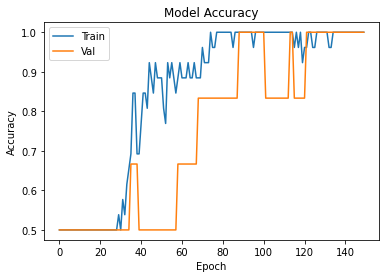

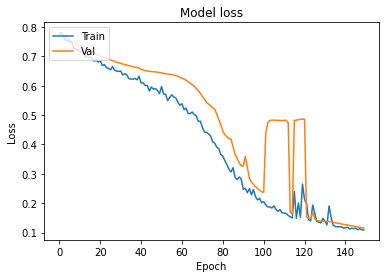

In [63]:
model= tf.keras.models.load_model('my_dir/gru/all-LSTM(256)curve5-89-0.34-1.00.h5')
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.evaluate(test,test_target)


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()